In [1]:
import rasterio

In [2]:
dataset = rasterio.open('/Users/domhardy/Desktop/REMA DEM/Wilkes Land merged tiffs.tif')

In [3]:
dataset.count

1

In [4]:
dataset.width

25000

In [5]:
dataset.height

25000

In [6]:
dataset.bounds

BoundingBox(left=800000.0, bottom=-600000.0, right=1000000.0, top=-400000.0)

In [7]:
dataset.transform

Affine(8.0, 0.0, 800000.0,
       0.0, -8.0, -400000.0)

In [8]:
dataset.crs

CRS.from_epsg(3031)

In [9]:
dataset.indexes

(1,)

In [10]:
band1 = dataset.read(1)

In [11]:
band1

array([[3094.5625, 3094.5977, 3094.6414, ..., 3271.415 , 3271.4167,
        3271.4377],
       [3094.5337, 3094.5715, 3094.6152, ..., 3271.414 , 3271.4058,
        3271.4146],
       [3094.5132, 3094.5532, 3094.5977, ..., 3271.428 , 3271.4124,
        3271.4119],
       ...,
       [2832.42  , 2832.3762, 2832.336 , ..., 3026.148 , 3026.1707,
        3026.213 ],
       [2832.4119, 2832.37  , 2832.3325, ..., 3026.1736, 3026.196 ,
        3026.237 ],
       [2832.4004, 2832.362 , 2832.3293, ..., 3026.205 , 3026.2275,
        3026.2673]], dtype=float32)

In [12]:
# Addressing individual point value from band array

In [13]:
band1[dataset.height // 2, dataset.width // 2]

3060.2302

In [14]:
# Spatial indexing

In [15]:
# get value 100km East and 50km South - change values accordingly
x, y = (dataset.bounds.left + 100000, dataset.bounds.top - 50000)
row, col = dataset.index(x, y)
row, col

(6250, 12500)

In [16]:
band1[row, col]

3138.3743

In [17]:
# GET SPATIAL COORDINATE
dataset.xy(dataset.height // 2, dataset.width // 2)

(900004.0, -500004.0)

In [18]:
# intersting geology method
# from
# https://portailsig.org/content/python-utilisation-des-couches-vectorielles-et-matricielles-dans-une-perspective-geologique-.html

In [4]:
from osgeo import gdal,ogr
# raster dem10m
file = '/Users/domhardy/Desktop/REMA DEM/Wilkes Land merged tiffs.tif'
layer = gdal.Open(file)
gt =layer.GetGeoTransform()
bands = layer.RasterCount
print(bands)


1


In [5]:
print(gt)

(800000.0, 8.0, 0.0, -400000.0, 0.0, -8.0)


In [6]:
x,y = (800000.0,-400000.0)
# transform to raster point coordinates
rasterx = int((x - gt[0]) / gt[1])
rastery = int((y - gt[3]) / gt[5])
# only one band here
print(layer.GetRasterBand(1).ReadAsArray(rasterx,rastery, 1, 1))
 

[[3094.5625]]


In [7]:
def Val_raster(x,y,layer,bands,gt):
    col=[]
    px = int((x - gt[0]) / gt[1])
    py =int((y - gt[3]) / gt[5])
    for j in range(bands):
        band = layer.GetRasterBand(j+1)
        data = band.ReadAsArray(px,py, 1, 1)
        col.append(data[0][0])
    return col

In [8]:
# with a DEM (1 band)
px1 = int((x - gt[0]) / gt[1])
py1 = int((y - gt[3]) / gt[5])
print(Val_raster(x,y,layer, bands,gt))
# elevation

[3094.5625]


In [9]:
# creation of an empty ogr linestring to handle all possible segments of a line with  Union (combining the segements)
profilogr = ogr.Geometry(ogr.wkbLineString)
# open the profile shapefile
source = ogr.Open('/Users/domhardy/Desktop/REMA DEM/Wilkes transect test.shp')
cshp = source.GetLayer()
# union the segments of the line
for element in cshp:
    geom = element.GetGeometryRef()
    profilogr = profilogr.Union(geom)

In [10]:
from shapely.wkb import loads
# transformation in Shapely geometry
profilshp = loads(profilogr.ExportToWkb())
# creation the equidistant points on the line with a step of 8m
lenght=profilshp.length
x = []
y = []
z = []
# distance of the topographic profile
distance = []

In [11]:
import decimal
def float_range(start, stop, step):
    while start < stop:
        yield float(start)
        start += decimal.Decimal(step)

In [12]:
for currentdistance  in float_range(0,lenght,8):
    point = profilshp.interpolate(currentdistance)
    xp,yp=point.x, point.y
    x.append(xp)
    y.append(yp)
    z.append(Val_raster(xp,yp,layer, bands,gt)[0])
    distance.append(currentdistance)

In [13]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

In [14]:
# cross sections(x, elevation from currentdistance (dista list))

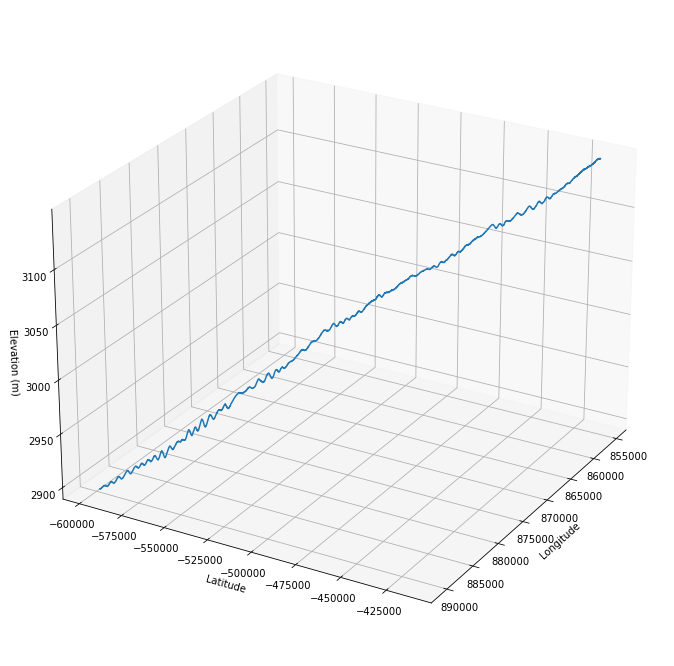

In [13]:
fig = plt.figure(figsize=(12,12))

ax = fig.add_subplot(111,projection='3d')
ax.plot(x,y,z)
ax.set_xlabel('Longitude')
ax.set_ylabel('Latitude')
ax.set_zlabel('Elevation (m)')
ax.view_init(25, 30)
plt.show()

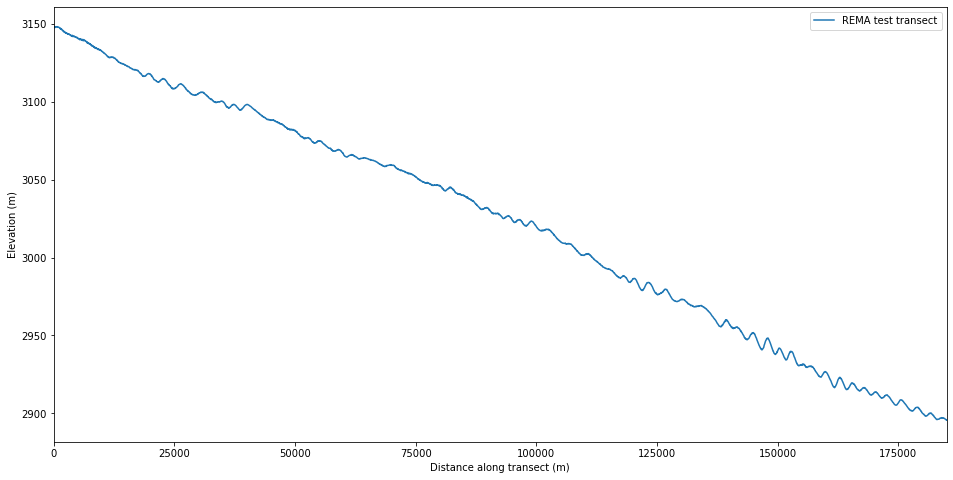

In [15]:
fig, ax = plt.subplots(figsize=(16,8))
ax.plot(distance, z, label='REMA test transect')
ax.set_xlabel('Distance along transect (m)')
ax.set_ylabel('Elevation (m)')
ax.set_xlim(0,185000)
plt.legend()
plt.show()

In [ ]:
# Peak detection algorithm to then identify frequency and amplitude and wavelength

In [2]:
import plotly.graph_objects as go
import pandas as pd
from scipy.signal import find_peaks

indices = find_peaks(z)[0]

fig, ax = plt.subplots(figsize=(16,8))
ax.plot(distance, z, label='REMA test transect')
ax.set_xlabel('Distance along transect (m)')
ax.set_ylabel('Elevation (m)')
ax.set_xlim(0,185000)
ax.scatter(x=indices,
    y=[z[j] for j in indices],
    mode='markers',
    marker=dict(
        size=8,
        color='red',
        symbol='cross'),
           name='Detected Peaks'
)
plt.legend()
plt.show()

fig = go.Figure()
fig.add_trace(go.Scatter(
    y=z,
    mode='lines+markers',
    name='Original Plot'
))

fig.add_trace(go.Scatter(
    x=indices,
    y=[z[j] for j in indices],
    mode='markers',
    marker=dict(
        size=8,
        color='red',
        symbol='cross'
    ),
    name='Detected Peaks'
))

NameError: name 'z' is not defined

In [ ]:
import fiona
import rasterio
import rasterio.plot
import matplotlib.pyplot as plt
import numpy as np
# from descartes import PolygonPatch

src = rasterio.open("/Users/domhardy/Desktop/REMA DEM/Wilkes Land merged tiffs.tif")

with fiona.open("/Users/domhardy/Desktop/REMA DEM/Wilkes transect test.shp", "r") as shapefile:
    features = [feature["geometry"] for feature in shapefile]

rasterio.plot.show((src, 1),cmap='gist_gray')
ax = plt.gca()

# patches = [PolygonPatch(feature) for feature in features]
# ax.add_collection(mpl.collections.PatchCollection(patches))

In [ ]:
# Generate Hillshade 

In [16]:
import warnings
from osgeo import gdal, osr
import numpy as np
import matplotlib.pyplot as plt
warnings.filterwarnings('ignore')

In [17]:
def raster2array(geotif_file):

    metadata = {}
    dataset = gdal.Open(geotif_file)
    metadata['array_rows'] = dataset.RasterYSize
    metadata['array_cols'] = dataset.RasterXSize
    metadata['bands'] = dataset.RasterCount
    metadata['driver'] = dataset.GetDriver().LongName
    metadata['projection'] = dataset.GetProjection()
    metadata['geotransform'] = dataset.GetGeoTransform()

    mapinfo = dataset.GetGeoTransform()
    metadata['pixelWidth'] = mapinfo[1]
    metadata['pixelHeight'] = mapinfo[5]

    metadata['ext_dict'] = {}
    metadata['ext_dict']['xMin'] = mapinfo[0]
    metadata['ext_dict']['xMax'] = mapinfo[0] + dataset.RasterXSize/mapinfo[1]
    metadata['ext_dict']['yMin'] = mapinfo[3] + dataset.RasterYSize/mapinfo[5]
    metadata['ext_dict']['yMax'] = mapinfo[3]

    metadata['extent'] = (metadata['ext_dict']['xMin'],metadata['ext_dict']['xMax'],
                          metadata['ext_dict']['yMin'],metadata['ext_dict']['yMax'])

    if metadata['bands'] == 1:
        raster = dataset.GetRasterBand(1)
        metadata['noDataValue'] = raster.GetNoDataValue()
        metadata['scaleFactor'] = raster.GetScale()

        # band statistics
        metadata['bandstats'] = {} #make a nested dictionary to store band stats in same
        stats = raster.GetStatistics(True,True)
        metadata['bandstats']['min'] = round(stats[0],2)
        metadata['bandstats']['max'] = round(stats[1],2)
        metadata['bandstats']['mean'] = round(stats[2],2)
        metadata['bandstats']['stdev'] = round(stats[3],2)

        array = dataset.GetRasterBand(1).ReadAsArray(0,0,metadata['array_cols'],metadata['array_rows']).astype(np.float)
        array[array==metadata['noDataValue']]=np.nan
        #array = array/metadata['scaleFactor']
        array = array[::-1] #inverse array because Python is column major
        return array, metadata

    elif metadata['bands'] > 1:
        print('More than one band ... need to modify function for case of multiple bands')

def array2raster(newRasterfn,rasterOrigin,pixelWidth,pixelHeight,array,epsg):

    cols = array.shape[1]
    rows = array.shape[0]
    originX = rasterOrigin[0]
    originY = rasterOrigin[1]

    driver = gdal.GetDriverByName('GTiff')
    outRaster = driver.Create(newRasterfn, cols, rows, 1, gdal.GDT_Byte)
    outRaster.SetGeoTransform((originX, pixelWidth, 0, originY, 0, pixelHeight))
    outband = outRaster.GetRasterBand(1)
    outband.WriteArray(array)
    outRasterSRS = osr.SpatialReference()
    outRasterSRS.ImportFromEPSG(epsg)
    outRaster.SetProjection(outRasterSRS.ExportToWkt())
    outband.FlushCache()

def plot_band_array(band_array,refl_extent,title,cbar_label,colormap='gist_earth',alpha=1):
    plt.imshow(band_array,extent=refl_extent,alpha=alpha);
    cbar = plt.colorbar(); plt.set_cmap(colormap);
    cbar.set_label(cbar_label,rotation=270,labelpad=20)
    plt.title(title); ax = plt.gca();
    ax.ticklabel_format(useOffset=False, style='plain') #do not use scientific notation #
    rotatexlabels = plt.setp(ax.get_xticklabels(),rotation=90) #rotate x tick labels 90 degree

def hillshade(array,azimuth,angle_altitude):
    azimuth = 360.0 - azimuth

    x, y = np.gradient(array)
    slope = np.pi/2. - np.arctan(np.sqrt(x*x + y*y))
    aspect = np.arctan2(-x, y)
    azimuthrad = azimuth*np.pi/180.
    altituderad = angle_altitude*np.pi/180.

    shaded = np.sin(altituderad)*np.sin(slope) + np.cos(altituderad)*np.cos(slope)*np.cos((azimuthrad - np.pi/2.) - aspect)

    return 255*(shaded + 1)/2


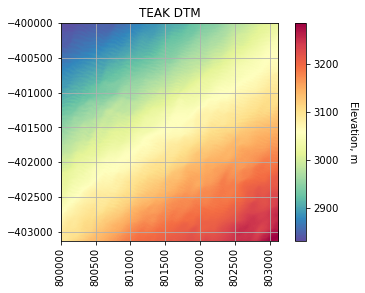

In [18]:
# Use raster2array to convert Geotif to array & plot
teak_dtm_array, teak_dtm_md = raster2array("/Users/domhardy/Desktop/REMA DEM/Wilkes Land merged tiffs.tif")
plot_band_array(teak_dtm_array,teak_dtm_md['extent'],'TEAK DTM','Elevation, m',colormap='Spectral_r')
ax = plt.gca(); plt.grid('on')

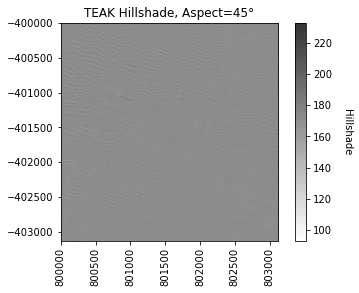

In [19]:
# Use hillshade function on a DTM Geotiff
teak_hillshade_array = hillshade(teak_dtm_array,45,20)
plot_band_array(teak_hillshade_array,teak_dtm_md['extent'],'TEAK Hillshade, Aspect=45°',
                'Hillshade',colormap='gist_gray_r',alpha=0.8)
ax = plt.gca() 

In [ ]:
# import shapefile as shp

# sf = shp.Reader("test.shp")
# for shape in sf.shapeRecords():
#     x = [i[0] for i in shape.shape.points[:]]
#     y = [i[1] for i in shape.shape.points[:]]

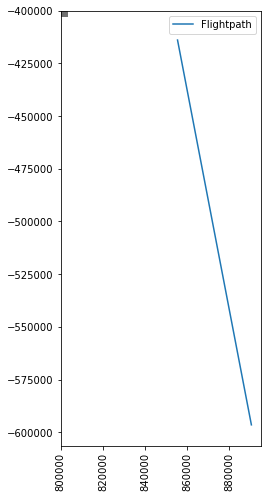

In [20]:
fig = plt.figure(frameon=False, figsize=(16,16))
im1 = plt.imshow(teak_dtm_array,cmap='terrain_r',extent=teak_dtm_md['extent']);
#cbar = plt.colorbar(); cbar.set_label('Elevation, m',rotation=270,labelpad=20)
im2 = plt.imshow(teak_hillshade_array,cmap='gist_gray_r',alpha=1,extent=teak_dtm_md['extent']);
ax=plt.gca(); ax.ticklabel_format(useOffset=False, style='plain') #do not use scientific notation
rotatexlabels = plt.setp(ax.get_xticklabels(),rotation=90) #rotate x tick labels 90 degrees
#plt.grid('on'); # plt.colorbar();
#plt.title('17_37 8m Hillshade')
ax=plt.plot(x,y, color ='black', label='Flightpath')
plt.legend()
plt.show()

In [ ]:
# NOT WORKING YET !!!!!!!!

In [21]:
# Python3 program for the above approach

# Python3 program for the above approach

# Function to find the amplitude and
# number of waves for the given array
def check(a, n):
	ma = a[1] - a[0]

	# Check for both sides adjacent
	# elements that both must be less
	# or both must be greater
	# than current element
	for i in range(1, n - 1):

		if ((a[i] > a[i - 1] and
			a[i + 1] < a[i]) or
			(a[i] < a[i - 1] and
			a[i + 1] > a[i])):

			# Update amplitude with max value
			ma = max(ma, abs(a[i] - a[i + 1]))

		else:
			return False

	# Prthe Amplitude
	print("Amplitude = ", ma)
	return True

# Driver Code
if __name__ == '__main__':

	# Given array a[]
	a = [1, 2, 1, 5, 0, 7, -6]
	n = len(a)

	# Calculate number of waves
	wave = (n - 1) // 2

	# Function Call
	if (check(a, n)):
		print("Waves = ",wave)
	else:
		print("-1")

# This code is contributed by Mohit Kumar



Amplitude =  13
Waves =  3
